# Grad CAM을 이용한 딥러닝 모형 해석
- http://freesearch.pe.kr/archives/4685

In [1]:
import pandas as pd
import numpy as np
from konlpy.tag import Mecab
from collections import Counter
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mecab = Mecab()

In [3]:
tbl = pd.read_csv("ratings_train.txt",sep='\t')

In [4]:
tbl.iloc[:10]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [5]:
keywords = [mecab.morphs(str(i).strip()) for i in tbl['document']]

In [6]:
print(len(keywords))

150000


In [7]:
from nltk.corpus import stopwords
keywords = [word for word in keywords if word not in stopwords.words('korean')]

In [8]:
print(len(keywords))

150000


In [7]:
np.median([len(k) for k in keywords]), len(keywords), tbl.shape

(14.0, 150000, (150000, 3))

In [8]:
keyword_cnt = Counter([i for item in keywords for i in item])


In [9]:
#간단하게 진행하기 위해 가장 빈도수가 많은 상위 5000개의 키워드만 사용한다. 
keyword_clip = sorted(keyword_cnt.items(), key=operator.itemgetter(1))[-5000:]

In [10]:
keyword_clip_dict = dict(keyword_clip)
keyword_dict = dict(zip(keyword_clip_dict.keys(), range(len(keyword_clip_dict))))

In [11]:
#공백과 미학습 단어 처리를 위한 사전 정보 추가  
keyword_dict['_PAD_'] = len(keyword_dict)
keyword_dict['_UNK_'] = len(keyword_dict) 

In [12]:
#키워드를 역추적하기 위한 사전 생성 
keyword_rev_dict = dict([(v,k) for k, v in keyword_dict.items()])

In [13]:
#리뷰 시퀀스 단어수의 중앙값 +5를 max 리뷰 시퀀스로 정함... 
max_seq =np.median([len(k) for k in keywords]) + 5

In [14]:
def encoding_and_padding(corp_list, dic, max_seq=50):
    from keras.preprocessing.sequence import pad_sequences
    coding_seq = [ [dic.get(j, dic['_UNK_']) for j in i]  for i in corp_list ]
    #일반적으로 리뷰는 마지막 부분에 많은 정보를 포함할 가능성이 많아 패딩은 앞에 준다. 
    return(pad_sequences(coding_seq, maxlen=max_seq, padding='pre', truncating='pre',value=dic['_PAD_']))

In [15]:
train_x = encoding_and_padding(keywords, keyword_dict, max_seq=int(max_seq))

Using TensorFlow backend.


In [16]:
train_y = tbl['label']

In [17]:
train_x.shape, train_y.shape

((150000, 19), (150000,))

In [18]:
from keras.models import *
from keras.layers import *
from keras.utils import *
from keras.optimizers import *
from keras.callbacks import *
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
import keras.backend as K

In [19]:
x_dim = train_x.shape[1]

In [20]:
inputs = Input(shape=(train_x.shape[1],), name='input')

In [21]:
embeddings_out = Embedding(input_dim=len(keyword_dict) , output_dim=50,name='embedding')(inputs)

conv0 = Conv1D(32, 1, padding='same')(embeddings_out)
conv1 = Conv1D(16, 2, padding='same')(embeddings_out)
conv2 = Conv1D(8, 3, padding='same')(embeddings_out)

pool0 = AveragePooling1D()(conv0)
pool1 = AveragePooling1D()(conv1)
pool2 = AveragePooling1D()(conv2)

concat_layer = concatenate([pool0, pool1, pool2],axis=2)

bidir =Bidirectional(GRU(10, recurrent_dropout=0.2, dropout=0.2))(concat_layer)

out = Dense(1,activation='sigmoid')(bidir)

model = Model(inputs=[inputs,], outputs=out)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [22]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 19)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 19, 50)       250100      input[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 19, 32)       1632        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 19, 16)       1616        embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_3 (

In [23]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy')
hist = model.fit(x=train_x,y=train_y, batch_size=100, epochs=10, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 135000 samples, validate on 15000 samples
Epoch 1/10
135000/135000 [==============================] - 29s 212us/step - loss: 0.4098 - val_loss: 0.3666
Epoch 2/10
135000/135000 [==============================] - 26s 195us/step - loss: 0.3537 - val_loss: 0.3443
Epoch 3/10
135000/135000 [==============================] - 26s 195us/step - loss: 0.3344 - val_loss: 0.3394
Epoch 4/10
135000/135000 [==============================] - 26s 194us/step - loss: 0.3232 - val_loss: 0.3333
Epoch 5/10
135000/135000 [==============================] - 27s 197us/step - loss: 0.3145 - val_loss: 0.3316
Epoch 6/10
135000/135000 [==============================] - 27s 203us/step - loss: 0.3067 - val_loss: 0.3356
Epoch 7/10
135000/135000 [==============================] - 26s 193us/step - loss: 0.3012 - val_loss: 0.3285
Epoch 8/10
135000/135000 [==============================] - 26s 190us/step - loss: 0.2947 - val_loss: 0.3303
Epoch 9/10
135000/135000 [===

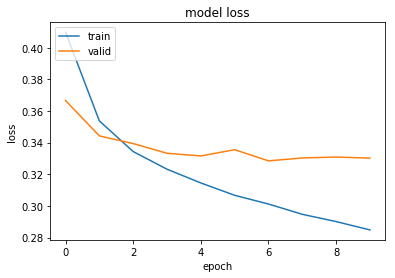

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [25]:
tbl_test = pd.read_csv("ratings_test.txt",sep='\t')

In [26]:
parsed_text = [mecab.morphs(str(i).strip()) for i in tbl_test['document']]

In [27]:
test_x = encoding_and_padding(parsed_text, keyword_dict, max_seq=int(max_seq))

In [28]:
test_y = tbl_test['label']

In [29]:
test_x.shape, test_y.shape

((50000, 19), (50000,))

In [30]:
prob = model.predict(test_x)

In [31]:
def grad_cam_conv1D(model, layer_nm, x, sample_weight=1,  keras_phase=0):
    import keras.backend as K
    import numpy as np
    
    #레이어 이름에 해당되는 레이어 정보를 가져옴 
    layers_wt = model.get_layer(layer_nm).weights
    layers = model.get_layer(layer_nm)
    layers_weights = model.get_layer(layer_nm).get_weights()
    
    #긍정 클래스를 설명할 수 있게 컨볼루션 필터 가중치의 gradient를 구함  
    grads = K.gradients(model.output[:,0], layers_wt)[0]
    
    #필터별로 가중치를 구함 
    pooled_grads = K.mean(grads, axis=(0,1))
    get_pooled_grads = K.function([model.input,model.sample_weights[0], K.learning_phase()], 
                         [pooled_grads, layers.output[0]])
    
    pooled_grads_value, conv_layer_output_value = get_pooled_grads([[x,], [sample_weight,], keras_phase])
    #다시한번 이야기 하지만 loss를 줄이기 위한 학습과정이 아니다... 
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:, i] *= pooled_grads_value[i]
    
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    return((heatmap, pooled_grads_value))

In [32]:
# test셋에서 90번째 인덱스에 해당하는 데이터를 시각화 해본다. 
idx = 90

In [33]:
prob[idx], tbl_test.iloc[idx], test_y[idx]

(array([0.02419925], dtype=float32),
 id                                                   9912932
 document    로코 굉장히 즐겨보는데, 이 영화는 좀 별로였다. 뭔가 사랑도 개그도 억지스런 느낌..
 label                                                      0
 Name: 90, dtype: object,
 0)

In [34]:
hm, graded = grad_cam_conv1D(model, 'conv1d_1', x=test_x[idx])

In [35]:
hm_tbl = pd.DataFrame({'heat':hm, 'kw':[keyword_rev_dict[i] for i in test_x[idx] ]})

In [36]:
print(hm_tbl)

            heat  kw
0  -2.569298e-06   ,
1  -7.849314e-06   이
2  -6.328186e-06  영화
3  -1.466852e-05   는
4  -1.663117e-05   좀
5  -3.918629e-06  별로
6  -7.650784e-06   였
7  -6.271362e-06   다
8  -9.201801e-08   .
9  -3.076444e-05  뭔가
10  4.863896e-05  사랑
11  6.621015e-06   도
12 -2.230201e-05  개그
13  6.621015e-06   도
14  4.649251e-06  억지
15 -2.250376e-05  스런
16 -1.777874e-05  느낌
17 -9.201801e-08   .
18 -9.201801e-08   .
